In [1]:
import pandas as pd
import numpy as np

df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import confusion_matrix, f1_score, classification_report, ConfusionMatrixDisplay
from bayes_opt import BayesianOptimization

In [3]:
df_train['DIED']

0         0
1         0
2         0
3         0
4         0
         ..
817594    0
817595    0
817596    0
817597    0
817598    0
Name: DIED, Length: 817599, dtype: int64

In [4]:
x_train = df_train.drop(columns = ['DIED'])
y_train = df_train['DIED']

x_test = df_test.drop(columns = ['DIED'])
y_test = df_test['DIED']


In [5]:
lr = LogisticRegression()

lr.fit(x_train, y_train)

LogisticRegression()

In [6]:
y_pred = lr.predict(x_test)

In [7]:
lr.predict_proba(x_test)

array([[0.5       , 0.5       ],
       [0.50000141, 0.49999859],
       [0.50000282, 0.49999718],
       ...,
       [0.76004564, 0.23995436],
       [0.76004667, 0.23995333],
       [0.7600477 , 0.2399523 ]])

In [8]:
lr.score(x_test, y_test)

0.9287377690802349

In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96    189834
           1       0.00      0.00      0.00     14566

    accuracy                           0.93    204400
   macro avg       0.46      0.50      0.48    204400
weighted avg       0.86      0.93      0.89    204400



c:\Users\Azadeh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Azadeh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Azadeh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
def objective_function(C, penalty):
    C = 10 ** C  # Convert C from log scale
    penalty = 'l1' if penalty < 0.5 else 'l2'  # Map to 'l1' or 'l2'
    
    # Create logistic regression model with specified parameters
    model = LogisticRegression(C=C, penalty=penalty, solver='liblinear', random_state=42)
    
    # Calculate cross-validated accuracy
    cv_accuracy = np.mean(cross_val_score(model, x_train, y_train, cv=5))
    
    return cv_accuracy

# Define parameter space
pbounds = {'C': (-3, 3), 'penalty': (0, 1)}  # Log scale for C, binary for penalty choice

# Run Bayesian optimization
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(init_points=5, n_iter=15)

# Print best parameters found
best_params = optimizer.max['params']
print("Best Parameters:", best_params)

|   iter    |  target   |     C     |  penalty  |
-------------------------------------------------
| 1         | 0.9278    | -0.7528   | 0.9507    |
| 2         | 0.9278    | 1.392     | 0.5987    |
| 3         | 0.9492    | -2.064    | 0.156     |
| 4         | 0.9278    | -2.651    | 0.8662    |
| 5         | 0.9278    | 0.6067    | 0.7081    |
| 6         | 0.9491    | -2.018    | 0.1643    |
| 7         | 0.9491    | 3.0       | 0.0       |
| 8         | 0.9278    | 3.0       | 0.8541    |
| 9         | 0.9491    | 2.475     | 0.0       |
| 10        | 0.9491    | -1.27     | 0.0       |
| 11        | 0.9481    | -3.0      | 0.0       |
| 12        | 0.9491    | -0.4174   | 0.0       |
| 13        | 0.9491    | 0.165     | 0.0       |
| 14        | 0.9491    | -1.788    | 0.0       |
| 15        | 0.9491    | 1.9       | 0.0       |
| 16        | 0.9491    | 0.8876    | 0.0       |
| 17        | 0.9491    | -2.558    | 0.0       |
| 18        | 0.9491    | 1.36      | 0.007099  |


In [11]:
# Train logistic regression model with best parameters
best_C = 10 ** best_params['C']  # Convert C from log scale
best_penalty = 'l1' if best_params['penalty'] < 0.5 else 'l2'  # Map to 'l1' or 'l2'

best_model = LogisticRegression(C=best_C, penalty=best_penalty, solver='liblinear', random_state=42)
best_model.fit(x_train, y_train)

# Evaluate performance
y_pred = best_model.predict(x_train)
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9492000357143294


In [13]:
y_test_predicted = best_model.predict(x_test)
F1 = f1_score(y_train,y_pred)
# best_model.predict_proba()
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97    758560
           1       0.71      0.50      0.59     59039

    accuracy                           0.95    817599
   macro avg       0.84      0.74      0.78    817599
weighted avg       0.94      0.95      0.95    817599



* Precision: out of people we thought die -> 71% actually died
* Recall: out of all people who actually died, 50% of them we got 1 

In [14]:
y_prob = best_model.predict_proba(x_test)[:, 1]

# Calculate AUC
auc_score = roc_auc_score(y_test, y_prob)
print("AUC Score:", auc_score)

AUC Score: 0.9631480671093301


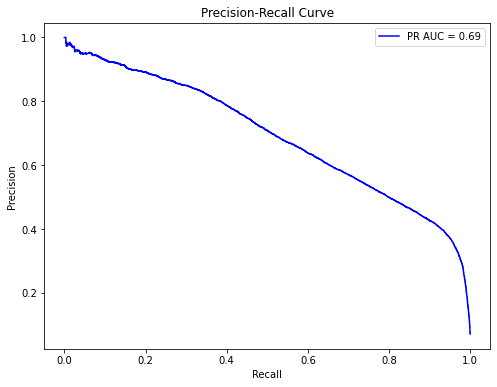

In [15]:
import matplotlib.pyplot as plt

 # Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

In [16]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(x_train, y_train)

GaussianNB()

In [17]:
y_train_predicted = clf.predict(x_train)
y_test_predicted = clf.predict(x_test)
F1 = f1_score(y_train,y_train_predicted)

print(classification_report(y_train,y_train_predicted))

c:\Users\Azadeh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Azadeh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.93      1.00      0.96    758560
           1       0.00      0.00      0.00     59039

    accuracy                           0.93    817599
   macro avg       0.46      0.50      0.48    817599
weighted avg       0.86      0.93      0.89    817599



c:\Users\Azadeh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


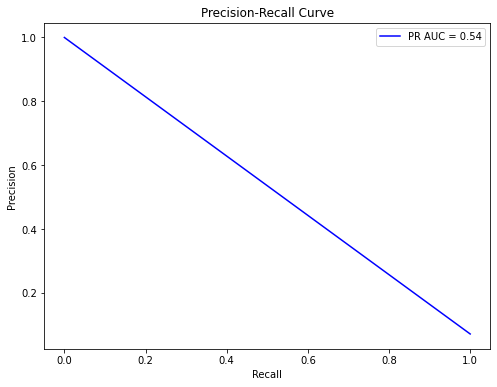

In [18]:
 # Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_test_predicted)
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

In [19]:
from sklearn.neural_network import MLPClassifier

ann = MLPClassifier(random_state=1, max_iter=500)
ann.fit(x_train, y_train)

y_train_predicted = ann.predict(x_train)
y_test_predicted = ann.predict(x_test)
F1 = f1_score(y_train,y_train_predicted)

print(classification_report(y_train,y_train_predicted))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96    758560
           1       0.75      0.00      0.00     59039

    accuracy                           0.93    817599
   macro avg       0.84      0.50      0.48    817599
weighted avg       0.91      0.93      0.89    817599



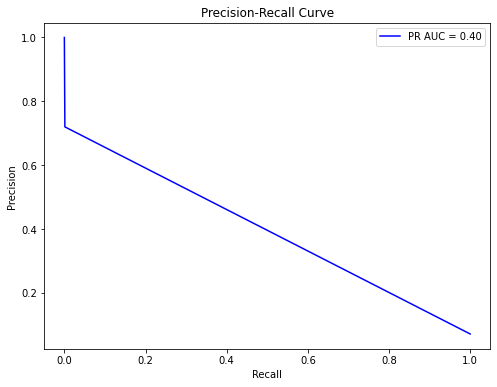

In [20]:
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_test_predicted)
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

Based on the AUC values, logistic regression model is the best for this data set.